In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

In [2]:
samples = 1000
dim = 250
dataset = np.random.randn(samples,dim)

In [3]:
eigenvalues, eigenvectors = np.linalg.eig(dataset.transpose().dot(dataset)/samples)
transformed_dataset = dataset.dot(eigenvectors)

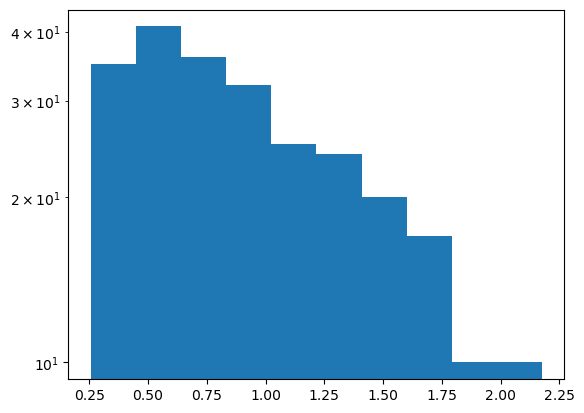

In [4]:
plt.hist(eigenvalues)
plt.yscale('log')

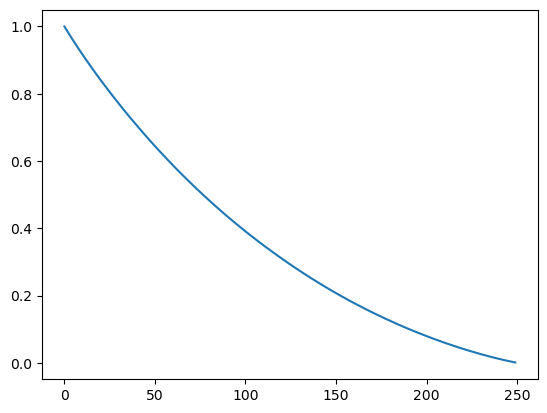

In [5]:
plt.plot(np.flip(np.cumsum(np.sort(eigenvalues))/eigenvalues.sum()))

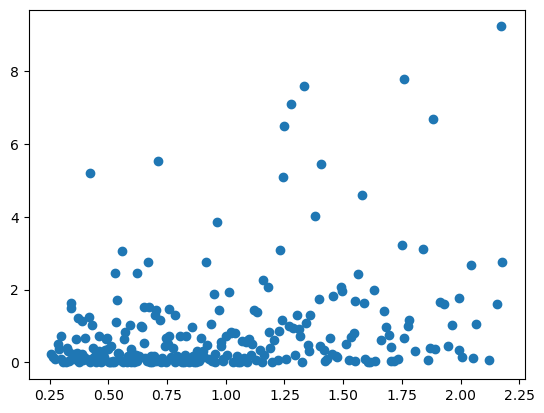

In [6]:
search_vector = np.random.randn(dim)
transformed_search_vector = eigenvectors.transpose().dot(search_vector)
variances = eigenvalues*transformed_search_vector**2
plt.scatter(eigenvalues, variances)

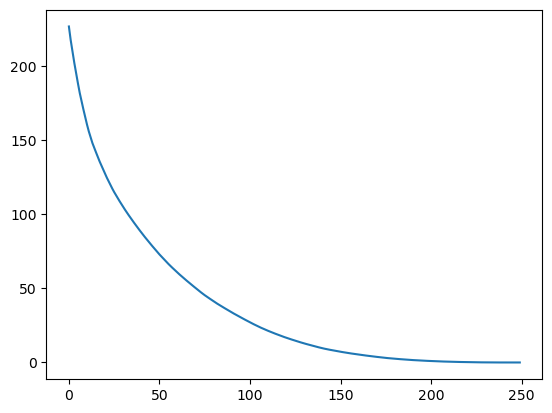

In [7]:
variance_remaining = np.flip(np.cumsum(np.sort(variances)))
plt.plot(variance_remaining)

In [8]:
df = pd.DataFrame({'eigenvalue':eigenvalues,'variance': variances, 'transformed_search_vector': transformed_search_vector})
df = df.sort_values(by='variance', ascending=False)
df

,eigenvalue,variance,transformed_search_vector
1,2.172298,9.224541,2.060690
23,1.760495,7.787006,-2.103138
75,1.334671,7.598811,2.386084
87,1.279707,7.086214,2.353162
14,1.882806,6.696320,-1.885886
...,...,...,...
242,0.784984,0.000361,-0.021456
234,0.863860,0.000303,0.018734
36,1.603994,0.000146,0.009526
133,1.092411,0.000057,-0.007217


In [9]:
pulls = np.zeros(samples, dtype='int')
means = samples*[0]
best_arms = pd.Series(dataset.dot(search_vector)).sort_values(ascending=False).index[:10]
best_arms_rank = []
top_arms_rank = []

In [10]:
true_rankings = dataset.dot(search_vector).argsort().argsort()

In [11]:
std_remaining = np.sqrt(variance_remaining)
for i in range(250000):
    rvs = scipy.stats.norm.rvs(means, variance_remaining[np.minimum(pulls,dim-1)])**2*(pulls<dim)+(pulls<dim) # Thompson Sampling - replace with cheaper bayesian bandit algorithm
    arm = rvs.argmax() 
    try:
        idx = df.index[pulls[arm]]
    except:
        print(rvs[arm])
        print(pulls[arm])
    means[arm] += transformed_search_vector[idx]*transformed_dataset[arm,idx]
    pulls[arm]+=1
    argsorted_means = np.argsort(means)
    best_arms_rank.append(argsorted_means.argsort()[best_arms])
    top_arms_rank.append(true_rankings[argsorted_means[-10:][::-1]])

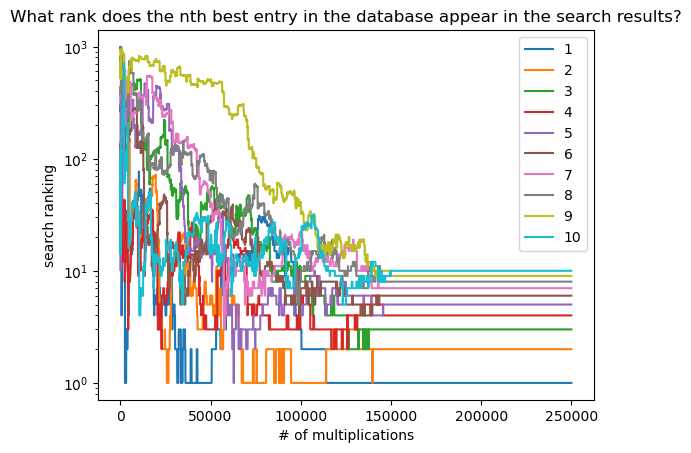

In [12]:
plt.plot(1000-np.array(best_arms_rank))
plt.yscale('log')
plt.title('What rank does the nth best entry in the database appear in the search results?')
plt.ylabel('search ranking')
plt.xlabel('# of multiplications')
plt.legend(np.arange(len(best_arms_rank[0]))+1)

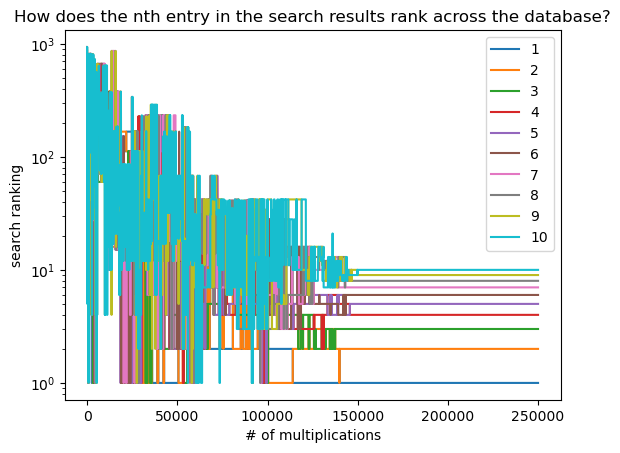

In [13]:
plt.plot(1000-np.array(top_arms_rank))
plt.yscale('log')
plt.title('How does the nth entry in the search results rank across the database?')
plt.ylabel('search ranking')
plt.xlabel('# of multiplications')
plt.legend(np.arange(len(best_arms_rank[0]))+1)

This assumes the absolute worst case scenario, in which each of the latent dimensions has the same variance, causing truncated PCA to be a poor approximation. Instead, if instead we assume that the variances follow an approximate zipf distribution, where Var(X_k) ~ 1/k, we get much better performance

In [14]:
dataset = np.random.randn(samples,dim)/np.sqrt(np.arange(dim)+1) # making the variances follow zipf's law
eigenvalues, eigenvectors = np.linalg.eig(dataset.transpose().dot(dataset)/samples)
transformed_dataset = dataset.dot(eigenvectors)

search_vector = np.random.randn(dim)/np.sqrt(np.arange(dim)+1) # making the variances follow zipf's law
transformed_search_vector = eigenvectors.transpose().dot(search_vector)
variances = eigenvalues*transformed_search_vector**2
variance_remaining = np.flip(np.cumsum(np.sort(variances)))

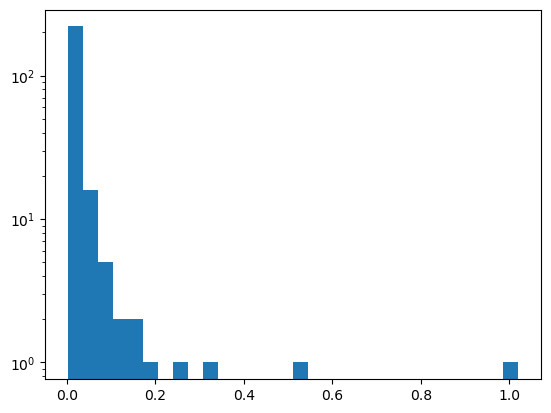

In [15]:
plt.hist(eigenvalues, bins = 30)
plt.yscale('log')

In [16]:
df = pd.DataFrame({'eigenvalue':eigenvalues,'variance': variances, 'transformed_search_vector': transformed_search_vector})
df = df.sort_values(by='variance', ascending=False)

In [17]:
pulls = np.zeros(samples, dtype='int')
means = samples*[0]
best_arms = pd.Series(dataset.dot(search_vector)).sort_values(ascending=False).index[:10]
best_arms_rank = []
top_arms_rank = []

In [18]:
true_rankings = dataset.dot(search_vector).argsort().argsort()

In [19]:
std_remaining = np.sqrt(variance_remaining)
for i in range(250000):
    rvs = scipy.stats.norm.rvs(means, variance_remaining[np.minimum(pulls,dim-1)])**2*(pulls<dim)+(pulls<dim) # Thompson Sampling - replace with cheaper bayesian bandit algorithm
    arm = rvs.argmax() 
    try:
        idx = df.index[pulls[arm]]
    except:
        print(rvs[arm])
        print(pulls[arm])
    means[arm] += transformed_search_vector[idx]*transformed_dataset[arm,idx]
    pulls[arm]+=1
    argsorted_means = np.argsort(means)
    best_arms_rank.append(argsorted_means.argsort()[best_arms])
    top_arms_rank.append(true_rankings[argsorted_means[-10:][::-1]])

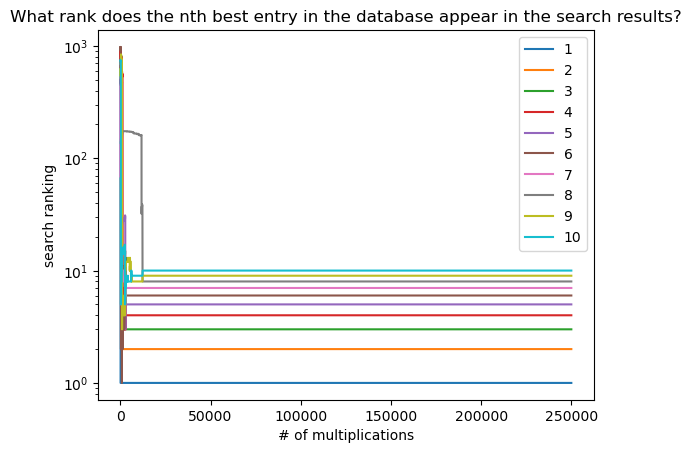

In [20]:
plt.plot(1000-np.array(best_arms_rank))
plt.yscale('log')
plt.title('What rank does the nth best entry in the database appear in the search results?')
plt.ylabel('search ranking')
plt.xlabel('# of multiplications')
plt.legend(np.arange(len(best_arms_rank[0]))+1)

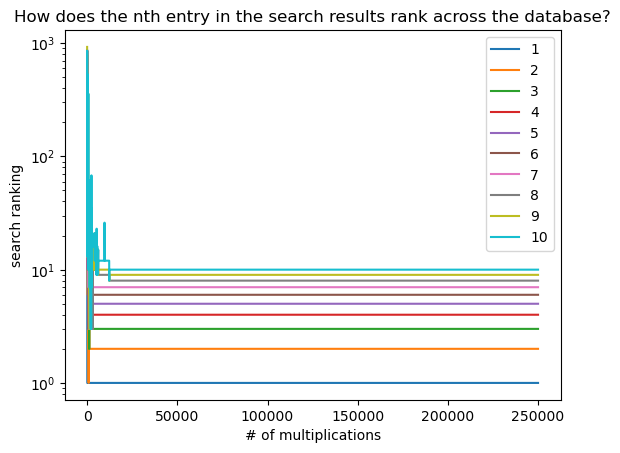

In [21]:
plt.plot(1000-np.array(top_arms_rank))
plt.yscale('log')
plt.title('How does the nth entry in the search results rank across the database?')
plt.ylabel('search ranking')
plt.xlabel('# of multiplications')
plt.legend(np.arange(len(best_arms_rank[0]))+1)